# Methoden en Technieken -- Blok 1

## Datapunt Opdracht

In deze opdracht worden de volgende leeruitkomsten getoetst, relevante termen zijn **dik** gedrukt:
- B2: Je stelt op basis van requirements een geschikte architectuur voor een AI-oplossing op en selecteert daarvoor passende AI-technieken, gebruik makend van **machine learning**, deep learning, kennisrepresentatie, computer vision, natural language processing en robotica.
- B3: Je prepareert een dataset voor het **trainen en testen** van een AI-model rekening houdend met technische en ethische randvoorwaarden.
- B4: **Je ontwikkelt, traint en evalueert een AI-model** volgens een iteratief proces.
- C2: **Je evalueert en beoordeelt de kwaliteit van een AI-model aan de hand van kwaliteitscriteria** die in het vakgebied erkend worden waaronder robustness, **performance**, scalability, explainability, model complexity en resource demand.

In deze opdracht gaan we opnieuw werken met de LFW dataset en *eigenfaces*, zie ook huiswerkopdracht 3 voor meer info. Doel is nu om een simpel gezichtsherkennings model te maken dat gebaseerd is op deze eigenfaces. Deze opdracht is gebaseerd op [Faces recognition example using eigenfaces and SVMs](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py) uit de **sklearn** documentatie, je mag gebruik maken van deze code voor deze opdracht maar het gebruik van een SVM voor de classificatietaak is niet toegestaan.

In [ ]:
## Warnings uitzetten
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Gebruikte libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA

De volgende code download de LFW dataset. We maken alleen gebruik van foto's van mensen die minstens 70 keer in de data voorkomen, en gebruiken foto's van relatief lage resolutie (50 pixels x 37 pixels).

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Achterhaal aantal en grootte van foto's
n_samples, h, w = lfw_people.images.shape

# Iedere rij in X is één foto, voor plotten zal
# dus een .reshape((h,w)) nodig zijn.
X = lfw_people.data
n_features = X.shape[1]

# y verwijsd naar een naam in target_names, sommige
# namen komen meerdere keren voor.
y = lfw_people.target
target_names = lfw_people.target_names

### De opdracht

- Voer een *principal component analyse* uit en achterhaal de *eigenfaces*.
- Train een classificatiemodel naar keuze op de *principal components*
  - Het is **niet** toegestaan een SVM te gebruiken
  - Geef in een markdown cel een argumentatie voor *alle* keuzes (ook gebruik maken van een *default* instelling is een keuze) die je maakt voor dit model. Houd hierbij rekening met de stof die we in de lessen hebben behandeld en de leerdoelen van deze opdracht.
- Beoordeel de kwaliteit van je model

De beoordeling van deze opdracht is voornamelijk gebaseerd op je uitvoering en argumentatie, en niet de behaalde kwaliteit. Je hoeft je model dus niet `zo goed mogelijk' te maken.

## 1 Exploratory data analyse

Ik voer een analyse uit om te kijken van welke beroemdheden er meer dan 70 afbeeldingen zijn in de data.

In [5]:
df = pd.DataFrame({'y':y}).merge(pd.DataFrame({'Name':target_names}), left_on='y', right_index=True)
df.value_counts(subset='Name')

Name
George W Bush        530
Colin Powell         236
Tony Blair           144
Donald Rumsfeld      121
Gerhard Schroeder    109
Ariel Sharon          77
Hugo Chavez           71
dtype: int64

Het gaat zo te zien om zeven beroemdheden, waarvan van George W. Bush veruit de meeste afbeeldingen aanwezig zijn in de dataset (530 van de 1288). Dit is een voorbeeld van een afbeelding van George W. Bush uit de dataset. Zoals in onderstaande afbeelding te zien, is de afbeelding van lage resolutie (50 x 37 pixels).

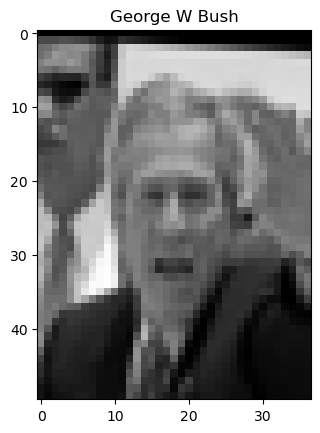

In [6]:
def plot_foto_bij_id(i):
    plt.imshow(X[i].reshape((h,w)), cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(target_names[y[i]])
    
plot_foto_bij_id(10)
plt.show()

## 2. Begin opdracht

In [7]:
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### 2.1 Split data

Om het model te kunnen testen zal de data gesplitst moeten worden in een train- en testset. Er is voor 75% traindata en 25% testdata gekozen, omdat de data zo goed verdeeld is om het model op te trainen en op te evalueren.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=34
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2.2 PCA uitvoeren (*eigenfaces*): feature extraction

In onderstaande cellen worden de dimensies van de afbeeldingen gereduceerd door principal component analyse (PCA) toe te passen. PCA wordt alleen uitgevoerd op de trainset, om ongeziene data beter te kunnen generaliseren (voorkomen van data-leakage).

In [9]:
n_components = 1287 # min(n_samples, n_features)=1288-1, de -1 wordt toegevoegd om zo alle componenten te analyseren en de scree-plot vloeiend te laten verlopen en duidelijk de variantie af te lezen.
pca = PCA(n_components = n_components).fit(X)
eigenfaces = pca.components_.reshape((-1, h, w))
X_pca = pca.transform(X)

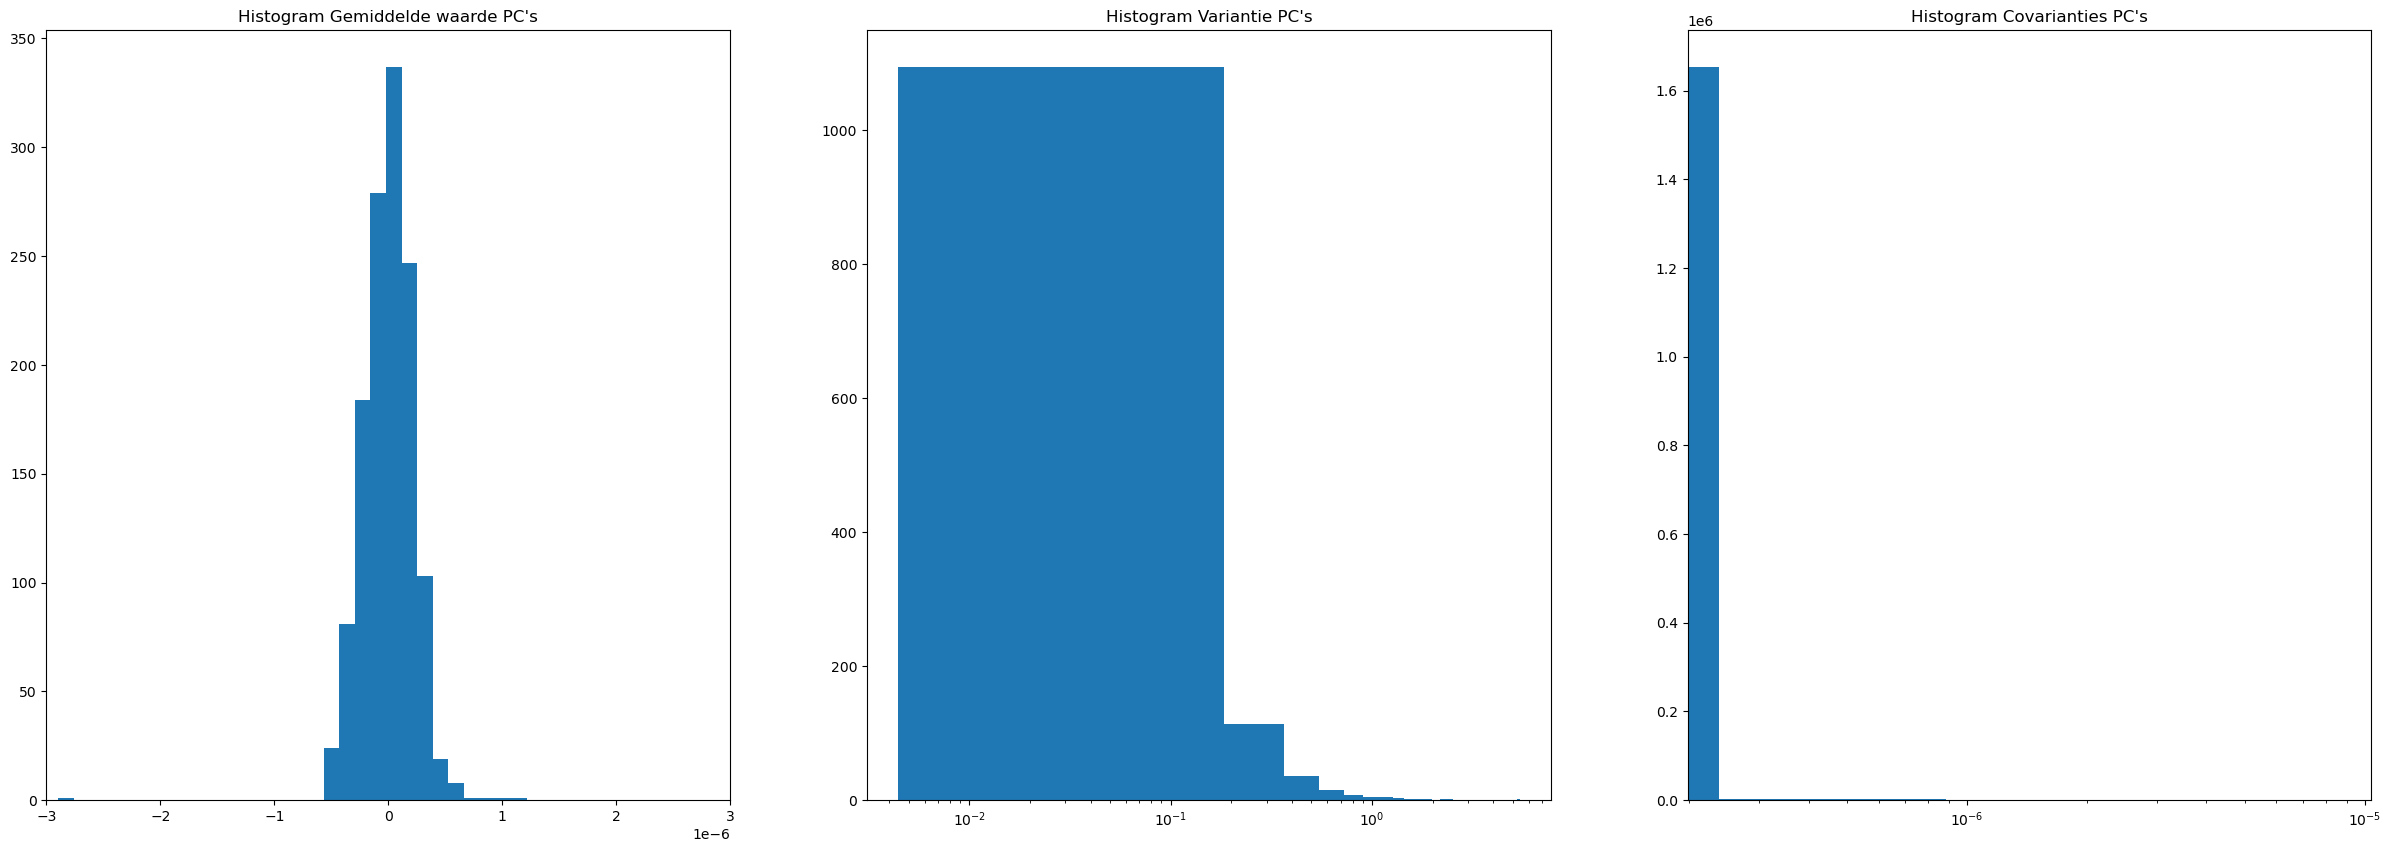

In [10]:
covmatrix = np.cov(X_pca, rowvar=False)
covmatrix[[range(n_components)],[range(n_components)]] = 0   # Zet varianties op diagnonaal op nul

plt.figure(figsize = (30,10))

plt.subplot(1,3,1)
plt.hist(X_pca.mean(axis=0), bins=30)
plt.xlim(-3e-6, 3e-6)   # op -3e-6 -- 3e-6 ingesteld, omdat verder geen uitschieters aanwezig zijn
plt.title("Histogram Gemiddelde waarde PC's")

plt.subplot(1,3,2)
plt.hist(X_pca.std(axis=0), bins=30)
plt.xscale('log')
plt.title("Histogram Variantie PC's")

plt.subplot(1,3,3)
plt.hist(covmatrix.reshape(-1), bins=30)
plt.xscale('log')
plt.title("Histogram Covarianties PC's")
plt.show()

De gemiddeldes lijken allemaal niet significant van nul te verschillen, op enkele uitschieters na. Hetzelfde geld voor de covarianties. Dus principle components (PC's) zijn gemiddeld nul en onderling ongecorreleerd. Standaardafwijkingingen zijn exponentieel verdeeld, meeste met orde 0,001 -- 1, met enkele uitschieters tussen de 1 en 10.

In onderstaande plots zijn een scree-plot geplot (links) en een plot van de cumulatieve variantie tegen het aantal componenten geplot (rechts) op alle aanwezige componenten om te bepalen hoeveel componenten nodig zijn voor de PCA om genoeg variantie te verklaren, zo dat het te fitten model de gezichten nog steeds kan herkennen met een klein deel van het aantal beschikbare eigenfaces.

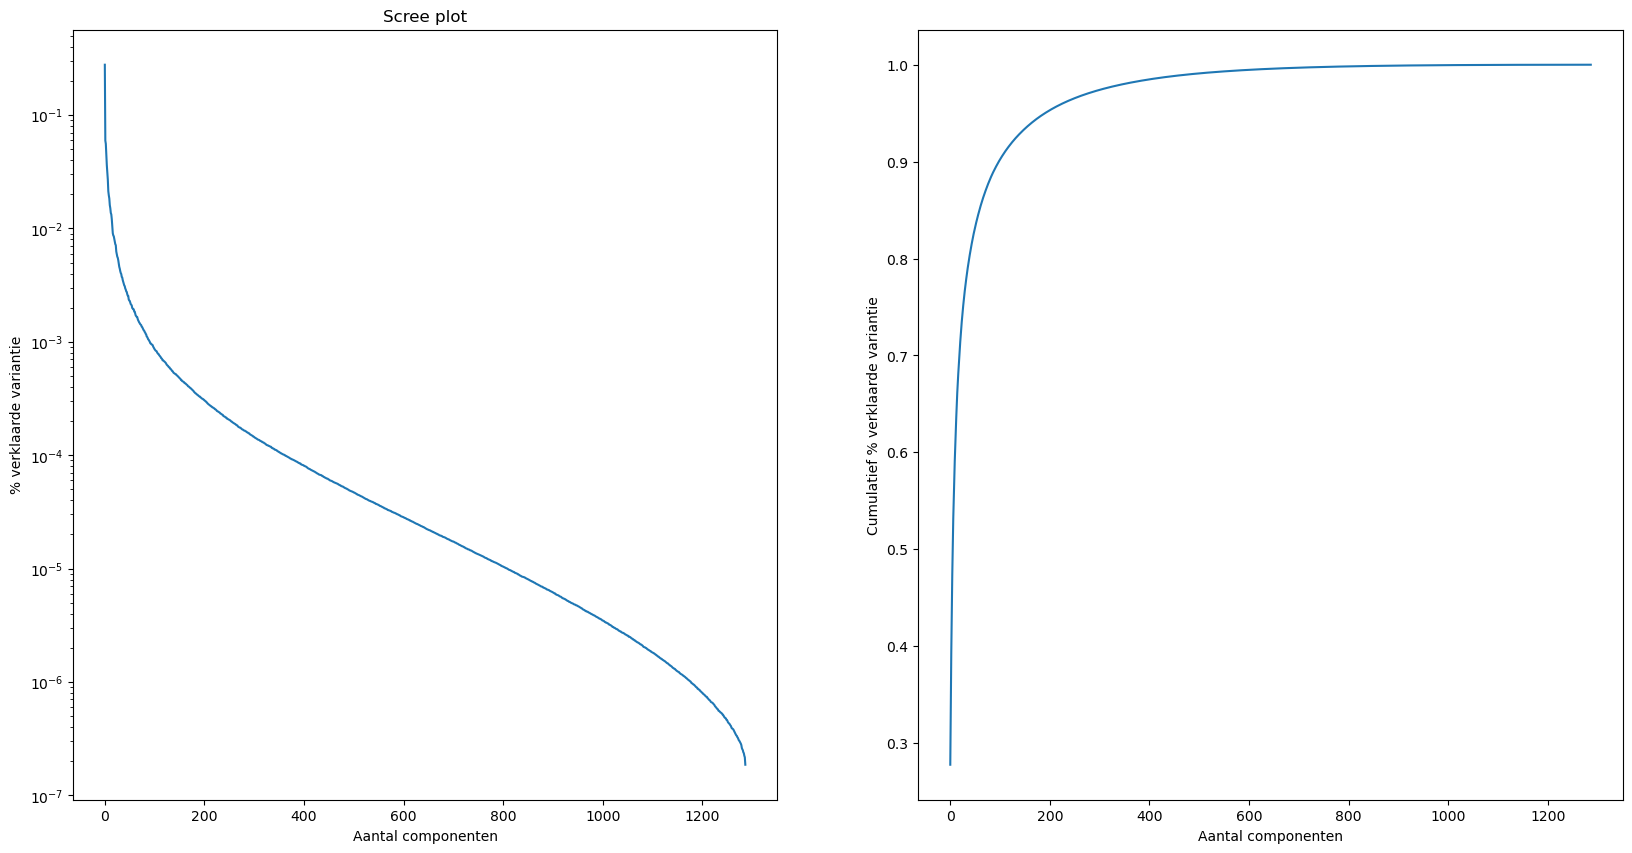

In [11]:
# Uitzoeken hoeveel eigenfaces nodig zijn om foto te reconstrueren
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(pca.explained_variance_ratio_)
plt.yscale('log')
plt.xlabel('Aantal componenten')
plt.ylabel('% verklaarde variantie')
plt.title('Scree plot')

plt.subplot(1,2,2)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Aantal componenten')
plt.ylabel('Cumulatief % verklaarde variantie')

plt.show()

Het lijkt erop dat je met 200 eigenfaces ongeveer 95% van de variantie verklaard, dat zou genoeg moeten zijn om de beroemdheden te herkennen. Vanaf 200 componenten verklaard ieder component minder dan 0.001% variantie. Om deze reden zal in het vervolg van deze opdracht met 200 componenten gewerkt worden.

In onderstaande subplots worden de 16 eigenfaces (PC's) geplot die de meeste variantie verklaren.

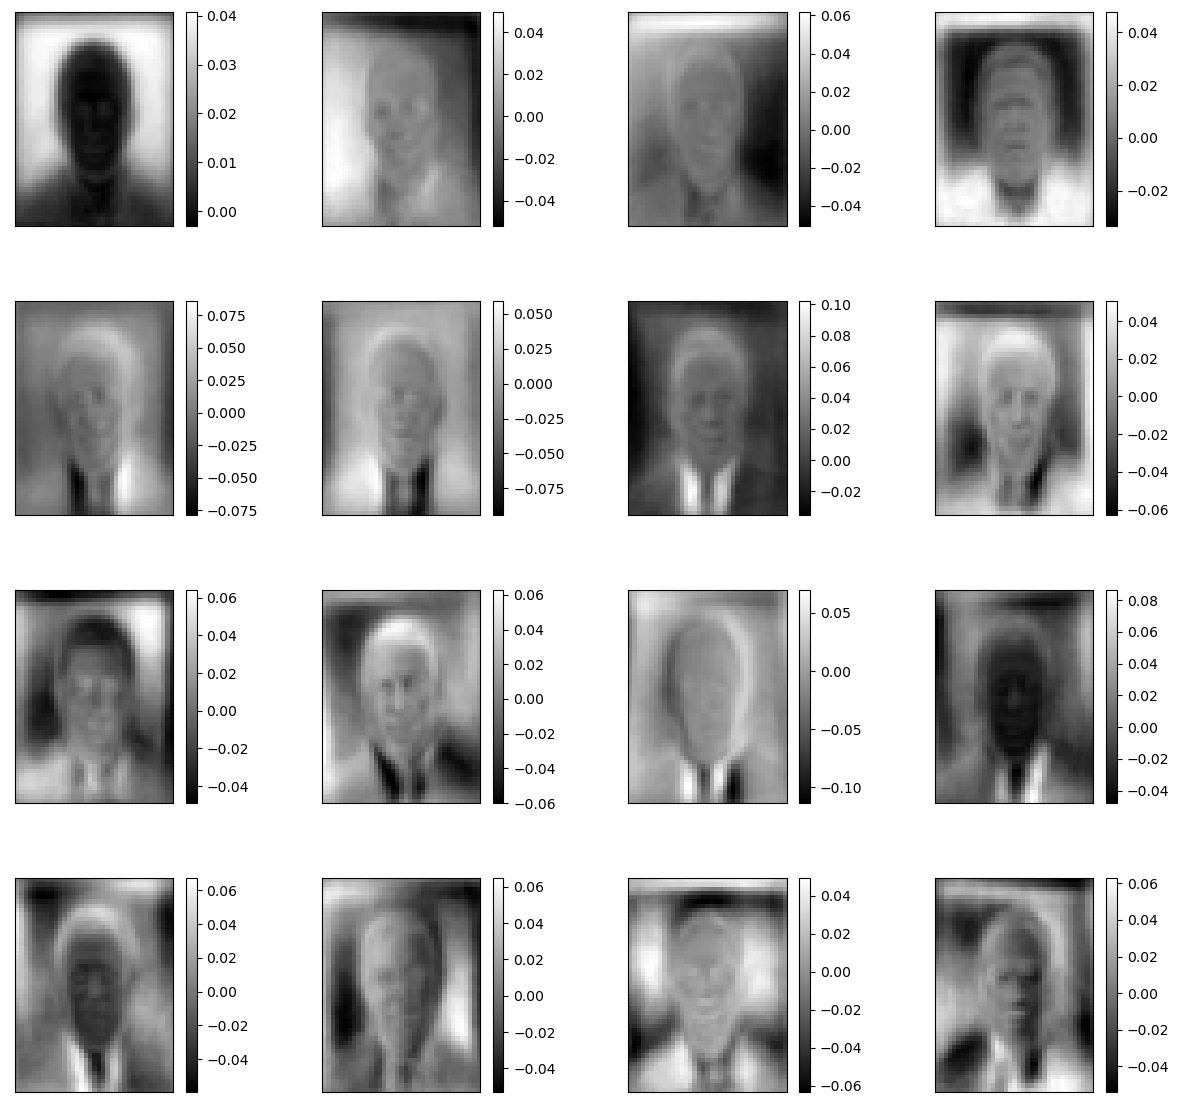

In [12]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(eigenfaces[i],cmap=plt.cm.gray)
    plt.colorbar()
    plt.xticks(())
    plt.yticks(())
plt.show()

In onderstaande code worden de 200 eigenfaces die de meeste variantie verklaren ontrokken uit de data om het aantal dimensies in de data te reduceren en zo met veel minder data alsof (bijna) even goede voorspellingen te doen. De parameterinstellingen voor de PCA zijn overgenomen uit de voorbeeldcode van [Faces recognition example using eigenfaces and SVMs](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py). De *whiten* parameter staat op true, om te zorgen voor ongecorreleerde outputs met componentgewijze varianties per eenheid.

In [13]:
n_components = 200

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 200 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis


### 2.3 Parameterinstellingen finetunen en model trainen

Nu gaan we proberen de zeven verschillende personen uit de LFW-dataset met elk minimaal 70 afbeeldingen van elkaar te onderscheiden. In de *abstract* van de paper [*Performance Evaluation of Machine Learning Classifiers for Face Recognition*](https://ieeexplore.ieee.org/document/9716171) van D. Sudiana, M. Rizkinia en F. Alamsyah (2021) staat beschreven dat er zeven classificiers getest zijn op gezichtsherkenning met behulp van PCA, waarbij op de CNN (convolutioneel neuraal netwerk) geen PCA is uitgevoerd, omdat een CNN al het vermogen heeft om feature extraction uit te voeren van zichzelf. Echter had de CNN de hoogste accuracy (98.75%), net zoals de SVM (98.75%). Aangezien de SVM niet gebruikt mag worden en de CNN van zichzelf al PCA gebruikt, zal de classifier gebruikt worden welke daarna het beste presteerde in de paper. Dat is de logistische regressie-classifier met een accuracy van 97.50%.

### Grid-searches

We zullen enkele parameters van het logistische regressie-model finetunen in deze opdracht. De te finetunen parameters zijn: *C*, *max_iter*, *multi_class*, *solver* en *penalty*. Dit omdat ik denk dat dit de parameters zijn die de meeste impact zullen hebben op het model. Veel parameters van het logistische regressie-model zijn alleen bruikbaar bij gebruik van bepaalde parameterinstellingen. Met deze parameters zal in deze opdracht geen rekening gehouden worden. 

De parameters *dual*, *intercept_scaling*, *verbose*, *l1-ratio* en *warm_start* zijn niet beschikbaar voor alle solvers. De parameter *n_jobs* is alleen voor *multi_class*='ovr' en de parameter *class_weight* moet voor allemaal gewicht 1 zijn, de ene beroemdheid is niet belangrijker dan de andere.

Allereerst gaan we kijken op hoeveel (op relatief grote schaal) de parameter *max_iter* ongeveer ingesteld moet worden, zodat bij de volgende grid-search met de andere parameters de grid-search van *max_iter* gelokaliseerd kan worden voor betere resultaten. Ook zal de solver met de beste resultaten op dit model bepaald worden, zal de *multi-class* parameter afgestemd worden en zal bepaald worden of de $L_1$- of $L_2$-straf voor betere prestaties zorgt.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

De parameter *random_state* wordt gebruikt om de data te shuffelen. Er wordt 5-fold cross-validatie uitgevoerd voor elk algoritme op het logistische regressie model. In dat geval wordt telkens 20% van de data gebruikt voor testen, wat over het algemeen goede resultaten geeft. Verder wordt 5-fold CV toegepast omdat de dataset relatief klein is. Bij veel meer data is het gebruikelijker om meer folds toe te passen, denk aan 10-folds.

In [16]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

parameters = {'C':np.arange(1, 10, 1), 'max_iter':[1,10,20,30,40,50,60,70,80,90,100]}

logistic = LogisticRegression(random_state=34)
logistic_model = logistic.fit(X_train_pca, y_train)

clf = GridSearchCV(logistic, parameters, cv=5)
clf.fit(X_train_pca, y_train)
report(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.805 (std: 0.027)
Parameters: {'C': 1, 'max_iter': 1}

Model with rank: 1
Mean validation score: 0.805 (std: 0.027)
Parameters: {'C': 2, 'max_iter': 1}

Model with rank: 1
Mean validation score: 0.805 (std: 0.027)
Parameters: {'C': 3, 'max_iter': 1}

Model with rank: 1
Mean validation score: 0.805 (std: 0.027)
Parameters: {'C': 4, 'max_iter': 1}

Model with rank: 1
Mean validation score: 0.805 (std: 0.027)
Parameters: {'C': 5, 'max_iter': 1}

Model with rank: 1
Mean validation score: 0.805 (std: 0.027)
Parameters: {'C': 6, 'max_iter': 1}

Model with rank: 1
Mean validation score: 0.805 (std: 0.027)
Parameters: {'C': 7, 'max_iter': 1}

Model with rank: 1
Mean validation score: 0.805 (std: 0.027)
Parameters: {'C': 8, 'max_iter': 1}

Model with rank: 1
Mean validation score: 0.805 (std: 0.027)
Parameters: {'C': 9, 'max_iter': 1}



De bovenstaande grid-search geeft aan dat alle beste modellen beschikken over een *max_iter* van 1. *C* lijkt de hoogste accuracy te geven op de defaultinstellingen ($C=1$, zie grid-search).  Laten we nu een grid-search doen op *max_iter* (gehele getallen tussen 1 en 10), *multi_class* en *solver* en een *penalty*.

In [17]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

parameters = {'max_iter':np.arange(1, 10, 1), 
              'multi_class':['auto', 'ovr', 'multinomial'], 
             'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
             'penalty':['l1', 'l2']}

logistic = LogisticRegression(random_state=34)
logistic_model = logistic.fit(X_train_pca, y_train)

clf = GridSearchCV(logistic, parameters, cv=5)
clf.fit(X_train_pca, y_train)
report(clf.cv_results_)

Model with rank: 1
Mean validation score: 0.821 (std: 0.024)
Parameters: {'max_iter': 3, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs'}

Model with rank: 1
Mean validation score: 0.821 (std: 0.024)
Parameters: {'max_iter': 3, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

Model with rank: 3
Mean validation score: 0.820 (std: 0.026)
Parameters: {'max_iter': 6, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga'}

Model with rank: 3
Mean validation score: 0.820 (std: 0.026)
Parameters: {'max_iter': 6, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}



Het LR-model zal uitgevoerd worden met de lbfgs-solver, aangezien deze solver de hoogste accuracy scoort (gemiddeld 82,1%) van de vijf beschikbare solvers voor logistische regressie (zie grid-search). auto als *multi_class* waarde geeft gemiddeld ook hogere resultaten dan auto en multinomial (zie grid-search). Een $L_2$-straf geeft de hoogste accuracy op het trainen. 

#### Logistische regressie fitten

Nu gaan we het logistische regressie-model met gekozen parameter-instellingen fitten en we zullen de accuracy van het gefitte LR-model printen.

In [18]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(random_state=34, multi_class="auto", solver="lbfgs", max_iter=3, penalty="l2")
logistic_model = logistic.fit(X_train_pca, y_train)

In [19]:
logistic_model.score(X_train_pca, y_train)

0.984472049689441

Het LR-model voorspelt 98,45% van de traindata correct op de huidige instellingen.

### 2.4 Model evaluatie

In onderstaande cellen wordt bovenstaand LR-model geevalueerd. Eerst zal de testdata losgelaten worden op het model om te kijken hoe goed het model presteert op ongeziende data. Vervolgens zal een confusion-matrix geplot worden met bijbehorende perfomance metrieken (precision, recall, f1-score) en worden deze indicatoren geanalyseerd en geinterpreteerd.

In [20]:
# print accuracy van het model
logistic_model.score(X_test_pca, y_test)

0.8509316770186336

Het logistische regressie-model scoort een accuracy van 85,09%. Dit betekent dat 85,09% van de testdata correct voorspeld is door het model.

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.73      0.70        11
     Colin Powell       0.90      0.87      0.88        60
  Donald Rumsfeld       0.70      0.75      0.72        28
    George W Bush       0.90      0.93      0.92       143
Gerhard Schroeder       0.79      0.72      0.75        32
      Hugo Chavez       0.75      0.69      0.72        13
       Tony Blair       0.82      0.80      0.81        35

         accuracy                           0.85       322
        macro avg       0.79      0.78      0.79       322
     weighted avg       0.85      0.85      0.85       322



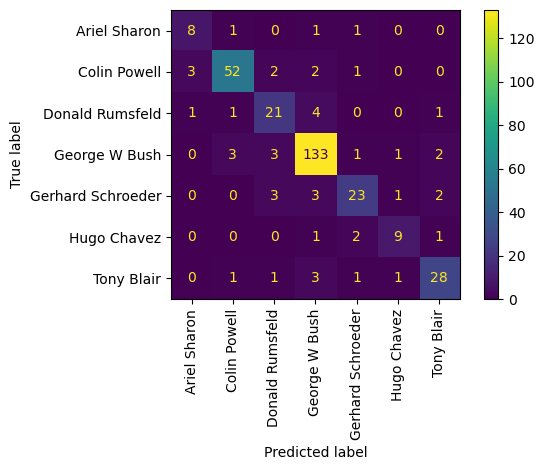

In [21]:
# print conf.-matrix en classificatie report op de testset

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
print("Predicting people's names on the test set")

y_pred = logistic_model.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    logistic_model, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Zoals in bovenstaande confusion-matrix te zien, worden bijna alle afbeeldingen in de testset goed voorspeld. Wat opvalt is dat George W. Bush relatief vaak correct voorspeld wordt ten opzichte van de anderen, met een $F1-score$ van $0,92$ ($precision=0,90$ en $recall=0,93$). Dit houdt in dat Bush 10% $(1-precision=1-\frac{146-14}{146}=\frac{14}{146}=10\%)$ van de afbeeldingen van iemand anders dan Bush zijn voorspeld als Bush en 7% $(1-recall=1-\frac{146-10}{146}=\frac{10}{146}=7\%)$ van de afbeeldingen die Bush moeten voorstellen, zijn niet voorspeld als Bush door het model.

In [22]:
# plot resultaten van voorspelling op PC's uit de testset
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In onderstaande plot zijn 12 subplots weergegeven van 12 verschillende afbeeldingen uit de dataset die enkel bestaan uit 200 eigenfaces. Bij elke foto staat wie de desbetreffende beroemdheid is en wat de voorspelde beroemdheid is volgens het model.

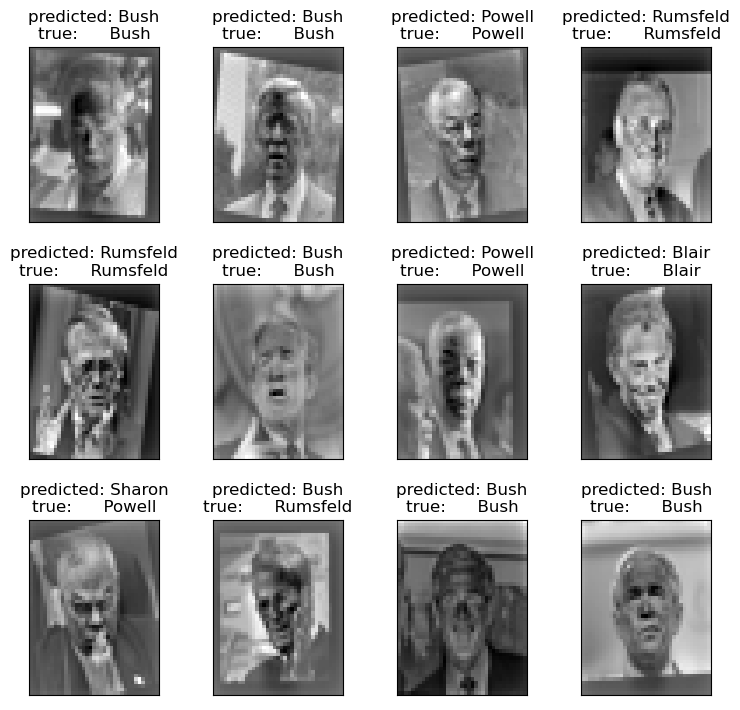

In [23]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)